## Import libraries

In [1]:
import pandas as pd
import numpy as np

# SK-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#XGBoost
import xgboost as xgb

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")

## Import dataset

In [2]:
df_original = pd.read_csv("DataFrameCityHotel_preprocesado.csv")
df = df_original.copy()
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,arrival_date,L.O.S.,Generates_Rev,room_pax,adr_cat
0,1,88,2015,7,1,0,4,2,0,0,...,Transient,76.5,0,1,Canceled,01/07/2015,4,0,2,Tipo2
1,1,65,2015,7,1,0,4,1,0,0,...,Transient,68.0,0,1,Canceled,01/07/2015,4,0,1,Tipo2
2,1,92,2015,7,1,2,4,2,0,0,...,Transient,76.5,0,2,Canceled,01/07/2015,6,0,2,Tipo2
3,1,100,2015,7,2,0,2,2,0,0,...,Transient,76.5,0,1,Canceled,02/07/2015,2,0,2,Tipo2
4,1,79,2015,7,2,0,3,2,0,0,...,Transient,76.5,0,1,Canceled,02/07/2015,3,0,2,Tipo2


In [3]:
df['Generates_Rev_bin'] = df['Generates_Rev'].astype(int)
df['adr_rev'] = df['adr'] * df['Generates_Rev_bin']

## K-Means

Let's use the K-means algorithm to cluster customers based on spending patterns. For this, we will use the following columns:

   adr_revev": This column provides information about the amount of revenue generated by each customer, which is a fundamental aspect of spending.
    "room_pax": This column can influence the total customer spending, as more occupants generally imply higher consumption of services and amenities.
    "L.O.S": This column also affects total spending, as a longer length of stay implies more nights of accommodation, consumption of services, and amenities.

### Normalize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['adr_rev', 'room_pax', 'L.O.S.']])

In [5]:
df_scaled

array([[-1.0533787 ,  0.07707732,  0.55357138],
       [-1.0533787 , -1.53093074,  0.55357138],
       [-1.0533787 ,  0.07707732,  1.65554805],
       ...,
       [ 1.5501613 ,  0.07707732,  2.20653639],
       [ 0.67009842,  0.07707732,  2.20653639],
       [ 1.44269161,  0.07707732,  3.30851306]])

In [6]:
df[['adr_rev', 'room_pax', 'L.O.S.']].head(10)

,adr_rev,room_pax,L.O.S.
0,0.00,2,4
1,0.00,1,4
2,0.00,2,6
3,0.00,2,2
4,0.00,2,3
5,58.67,1,3
6,0.00,1,4
7,76.50,2,5
8,76.50,2,5
9,86.00,2,2


In [7]:
df.shape

(77858, 33)

In [8]:
# Create columns with normalized data
df['adr_rev_scaled'] = df_scaled[:, 0] 
df['room_pax_scaled'] = df_scaled[:, 0] 
df['L.O.S_scaled'] = df_scaled[:, 1] 

In [9]:
range_n_clusters = range(2, 11)
wcss_values = []
silhouette_avg_values = []

In [10]:
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_scaled)
    wcss = kmeans.inertia_
    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
    wcss_values.append(wcss)
    silhouette_avg_values.append(silhouette_avg)

  File "C:\Users\ivanp\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


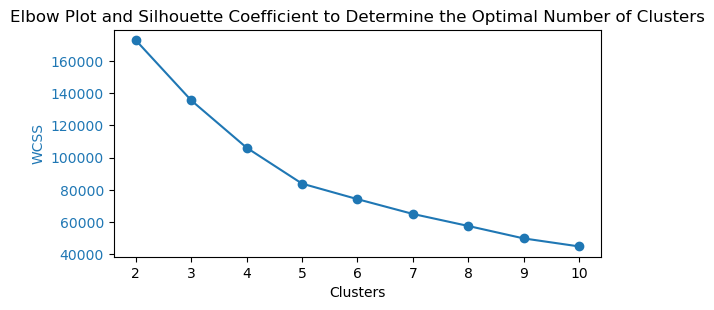

In [11]:
fig, ax1 = plt.subplots(figsize=(6, 3))

color = 'tab:blue'
ax1.set_xlabel('Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range_n_clusters, wcss_values, marker='o', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # Ajuste layout para la gráfica
plt.title('Elbow Plot and Silhouette Coefficient to Determine the Optimal Number of Clusters')
plt.show()

Based on the elbow plot, a value of k=4 appears to be most suitable for this analysis. At this point, the within-cluster sum of squares (WCSS) curve starts to flatten, indicating that adding more clusters does not significantly improve clustering. Additionally, the average silhouette coefficient reaches its maximum at k=4, indicating better separation between clusters and higher cohesion within them.

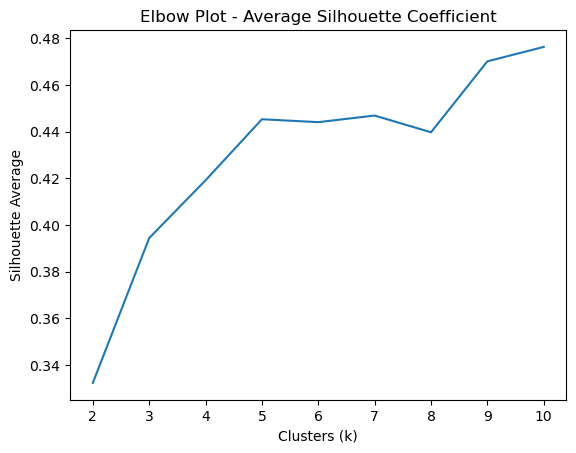

In [12]:
plt.plot(range_n_clusters, silhouette_avg_values)
plt.title('Elbow Plot - Average Silhouette Coefficient')
plt.xlabel('Clusters (k)')
plt.ylabel('Silhouette Average')
plt.show()

Based on the elbow plot, there is no clearly defined value of k as the optimal number of clusters. However, the values k=5 and k=7 could be considered as potentially good options. Given that the WCSS curve commonly suggests 4 as the number of clusters, we will use that number of clusters.

#### K-Means

In [13]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(df[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']]) # normalized above
df['cluster'] = kmeans.labels_

In [14]:
# Access the centroids
centroides = kmeans.cluster_centers_
centroides

array([[-1.04785417, -1.04785417,  0.03029818],
       [ 1.66812116,  1.66812116,  1.86230205],
       [ 0.63100851,  0.63100851,  0.10375857],
       [ 0.51683284,  0.51683284, -1.53093074]])

In [15]:
# Denormalize
centroides_desnormalizados = scaler.inverse_transform(centroides)
centroides_desnormalizados

array([[  0.33464936,   1.30041924,   3.05030077],
       [164.85544415,   2.98945017,   6.37524205],
       [102.03212048,   2.34448284,   3.18362553],
       [ 95.11590422,   2.27347843,   0.21679447]])

#### Scatter Plot

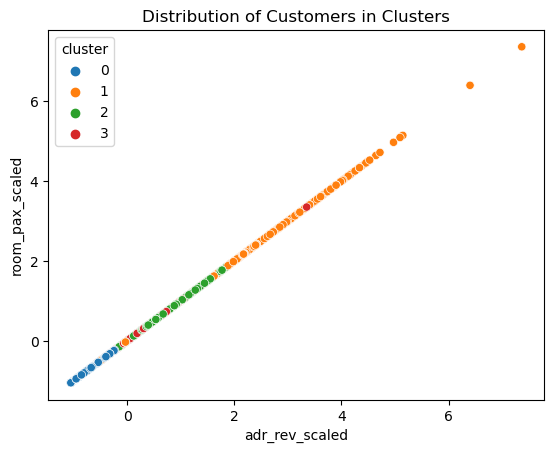

In [16]:
sns.scatterplot(
    x="adr_rev_scaled",
    y="room_pax_scaled",
    hue="cluster",
    data=df,
    palette="tab10",  # Use an appropriate color palette for 10 clusters
)
plt.title("Distribution of Customers in Clusters")
plt.show()

#### PCA

The goal of performing PCA is to reduce the dimensionality of the data and visualize it in a two-dimensional space

In [17]:
df_pca = df.copy()
pca = PCA(n_components=2) 
pca.fit(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])

PCA(n_components=2)

In [18]:
df_pca['pca_component_1'] = pca.transform(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])[:, 0]
df_pca['pca_component_2'] = pca.transform(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])[:, 1]

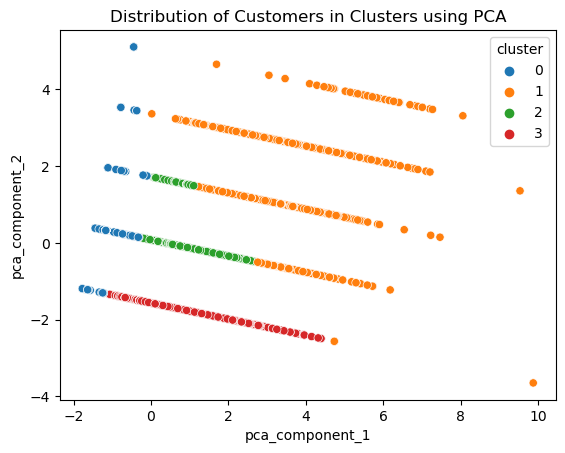

In [19]:
sns.scatterplot(
    x="pca_component_1",
    y="pca_component_2",
    hue="cluster",
    data=df_pca,
    palette="tab10",
)
plt.title("Distribution of Customers in Clusters using PCA")
plt.show()

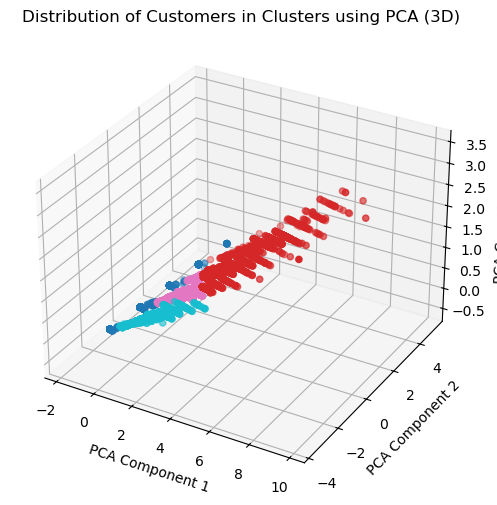

In [20]:
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

pca = PCA(n_components=3)  
pca.fit(df[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])
df_pca['pca_component_1'] = pca.transform(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])[:, 0]
df_pca['pca_component_2'] = pca.transform(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])[:, 1]
df_pca['pca_component_3'] = pca.transform(df_pca[['adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled']])[:, 2]


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_pca['pca_component_1'], df_pca['pca_component_2'], df_pca['pca_component_3'], c=df_pca['cluster'], cmap='tab10')

# Customize plot elements
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('Distribution of Customers in Clusters using PCA (3D)')

plt.show()

_____

# Forecasting

## XGBoost

- Our target variable is "is_canceled".
- We transform categorical variables into numerical variables using LabelEncoder.
- We split the dataset into train/test sets.
- We use GridSearch to find the best combination of parameters.
- We train the model.
- We evaluate the model (we can use accuracy_score(), recall_score(), and roc_auc_score()).
- We adjust hyperparameters if the performance is not satisfactory (we can use GridSearch() or RandomizedSearchCV()).
- Interpretation of the model using plot_importance()ance().rpretación del modelo `plot_importance()`
9. 

In [21]:
df_encoded = df.copy()

In [22]:
df_encoded.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,L.O.S.,Generates_Rev,room_pax,adr_cat,Generates_Rev_bin,adr_rev,adr_rev_scaled,room_pax_scaled,L.O.S_scaled,cluster
0,1,88,2015,7,1,0,4,2,0,0,...,4,0,2,Tipo2,0,0.0,-1.053379,-1.053379,0.077077,0
1,1,65,2015,7,1,0,4,1,0,0,...,4,0,1,Tipo2,0,0.0,-1.053379,-1.053379,-1.530931,0
2,1,92,2015,7,1,2,4,2,0,0,...,6,0,2,Tipo2,0,0.0,-1.053379,-1.053379,0.077077,0
3,1,100,2015,7,2,0,2,2,0,0,...,2,0,2,Tipo2,0,0.0,-1.053379,-1.053379,0.077077,0
4,1,79,2015,7,2,0,3,2,0,0,...,3,0,2,Tipo2,0,0.0,-1.053379,-1.053379,0.077077,0


In [23]:
df_encoded.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status', 'arrival_date',
       'L.O.S.', 'Generates_Rev', 'room_pax', 'adr_cat', 'Generates_Rev_bin',
       'adr_rev', 'adr_rev_scaled', 'room_pax_scaled', 'L.O.S_scaled',
       'cluster'],
      dtype='object')

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77858 entries, 0 to 77857
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     77858 non-null  int64  
 1   lead_time                       77858 non-null  int64  
 2   arrival_date_year               77858 non-null  int64  
 3   arrival_date_month              77858 non-null  int64  
 4   arrival_date_day_of_month       77858 non-null  int64  
 5   stays_in_weekend_nights         77858 non-null  int64  
 6   stays_in_week_nights            77858 non-null  int64  
 7   adults                          77858 non-null  int64  
 8   children                        77858 non-null  int64  
 9   babies                          77858 non-null  int64  
 10  meal                            77858 non-null  object 
 11  country                         77858 non-null  object 
 12  market_segment                  

In [25]:
df_encoded.deposit_type

0        No Deposit
1        No Deposit
2        No Deposit
3        No Deposit
4        No Deposit
            ...    
77853    No Deposit
77854    No Deposit
77855    No Deposit
77856    No Deposit
77857    No Deposit
Name: deposit_type, Length: 77858, dtype: object

In [26]:
# Convert the object variables using Label Encoding
label_encoder = LabelEncoder()
object_cols = df_encoded.select_dtypes(include=['object']).columns
for col in object_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

In [27]:
# Tengo que quedarme con el subdf de las no canceladas
# Desordeno aleatoriamente
# Me quedo con las priemras 30K filas (igualando el numero de muestra de si canceladas)
# Uno en df de las canceladas con las no canceladas, quedando un df con paridad entre canceladas y no canceladas

In [28]:
df_not_canceled = df_encoded[df_encoded['is_canceled'] == 0]
df_not_canceled.shape

(44981, 37)

In [29]:
df_canceled = df_encoded[df_encoded['is_canceled'] == 1]
df_canceled.shape

(32877, 37)

In [30]:
# Number of rows to be removed to balance the samples for training the dataframe
num_rows_to_drop = df_not_canceled.shape[0] - df_canceled.shape[0] 
# Drop rows
rows_to_drop = df_not_canceled.sample(n=num_rows_to_drop, random_state=42)

In [31]:
df_not_canceled = df_not_canceled.drop(rows_to_drop.index)

In [32]:
print("df_not_canceled.shape", df_not_canceled.shape)
print("df_canceled.shape",df_canceled.shape)

df_not_canceled.shape (32877, 37)
df_canceled.shape (32877, 37)


In [33]:
# concatenate the two dataframes that we will use to train the model and shuffle the rows

df_model = pd.concat([df_not_canceled, df_canceled]).drop(['reservation_status'], axis = 1)
df_model = df_model.sample(frac=1, random_state=42) #sample() con frac = 1 selects a fraction equal to 100% of the dataframe

In [34]:
#Once we have the balanced dataframe, we proceed to declare training variables and split it into train and test sets.

In [35]:
X = df_model.drop(['is_canceled'], axis=1)
y = df_model['is_canceled']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(49315, 35)
(49315,)
(16439, 35)
(16439,)


In [37]:
# Define XGBoost model
model_xgb = xgb.XGBClassifier(objective='binary:logistic')

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 1, 5],
    'reg_lambda': [0.1, 1, 10],
}

In [39]:
grid_search = GridSearchCV(estimator=model_xgb, 
                          param_grid=param_grid, 
                          scoring='accuracy',
                           error_score='raise',
                          cv=5,
                          n_jobs=-1)

In [40]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 1, 5], 'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'reg_lambda': [0.1, 1, 10]},
             scoring='accuracy')

In [41]:
# determine which model and parameters are best using GridSearch
mejor_modelo = grid_search.best_estimator_
mejores_parametros = grid_search.best_params_

In [42]:
mejores_parametros

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'reg_lambda': 0.1}

In [43]:
y_pred = mejor_modelo.predict(X_test)
y_pred.shape

(16439,)

In [44]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("y_test: " ,y_test.shape)
print("y_pred: ",y_pred.shape)

X_train:  (49315, 35)
y_train:  (49315,)
y_test:  (16439,)
y_pred:  (16439,)


In [45]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Precisión:", accuracy)
print("Recall:", recall) # Measure the proportion of actual positive instances that the model correctly identifies
print("AUC-ROC:", auc)

Precisión: 0.989050428858203
Recall: 0.9794603791929996
AUC-ROC: 0.9890603564458483


In [46]:
# The values provided by our model are very good; we proceed to verify the effectiveness of the model

#### VERIFY THE EFFECTIVENESS OF THE MODEL

In [47]:
# Check the model with the sample of 100 rows named `test_not_cancel_1`.
test_not_cancel_1 = df_not_canceled.sample(n=100)
X_sample = test_not_cancel_1.drop(['is_canceled', 'reservation_status'], axis=1)  #
y_sample = test_not_cancel_1['is_canceled']  

In [48]:
# Make predictions on the sample.
y_sample_pred = mejor_modelo.predict(X_sample)
y_sample_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
# Calculate the metrics on the sample
accuracy_sample = accuracy_score(y_sample, y_sample_pred)
recall_sample = recall_score(y_sample, y_sample_pred)


print(f"Accuracy on sample: {accuracy_sample}")
print(f"Recall on sample: {recall_sample}")


Accuracy on sample: 1.0
Recall on sample: 0.0


In [50]:
# Check the model with the sample of 100 rows named test_not_cancel_1.
test_not_cancel_1 = df_canceled.sample(n=100)
X_sample = test_not_cancel_1.drop(['is_canceled', 'reservation_status'], axis=1)  #
y_sample = test_not_cancel_1['is_canceled']  

In [51]:
# Make predictions on the sample
y_sample_pred = mejor_modelo.predict(X_sample)
y_sample_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
# Calculate the metrics on the sample
accuracy_sample = accuracy_score(y_sample, y_sample_pred)
recall_sample = recall_score(y_sample, y_sample_pred)


print(f"Accuracy on sample: {accuracy_sample}")
print(f"Recall on sample: {recall_sample}")

Accuracy on sample: 1.0
Recall on sample: 1.0


In [53]:
df_ = df.copy()

In [54]:
df_ = df_[['arrival_date_year', 'arrival_date_month',
       'arrival_date_day_of_month','adults','children','L.O.S.', 'adr','is_canceled']]

In [55]:
df_.head()

,arrival_date_year,arrival_date_month,arrival_date_day_of_month,adults,children,L.O.S.,adr,is_canceled
0,2015,7,1,2,0,4,76.5,1
1,2015,7,1,1,0,4,68.0,1
2,2015,7,1,2,0,6,76.5,1
3,2015,7,2,2,0,2,76.5,1
4,2015,7,2,2,0,3,76.5,1


In [56]:
# Puesto que queremos saber cual es el gasto, eliminamos aquellas reservas que han sido canceladas
df_ = df_[df_['is_canceled'] == 0]  

# Eliminar la columna "is_canceled"
df_.drop(columns=['is_canceled'], inplace=True)

# Crear una nueva columna que se llame "Total_rev" en la que multiplicamos el adr por el LOS
df_['Total_rev'] = df_['adr'] * df_['L.O.S.']

# Crear una nueva columna que se llame "Res_date" en formato datetime en la que convertiremos los datos de fecha
df_['Res_date'] = pd.to_datetime(df_[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1))

# Eliminar las columnas "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"
df_.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], inplace=True)

In [57]:
df_.head()

,adults,children,L.O.S.,adr,Total_rev,Res_date
5,1,0,3,58.67,176.01,2015-07-02
9,2,0,2,86.00,172.00,2015-07-03
10,2,0,2,43.00,86.00,2015-07-03
11,2,0,2,86.00,172.00,2015-07-03
12,1,0,2,63.00,126.00,2015-07-03


In [58]:
# Dividir el df 3 dataframes diferentes:
        # df_2pax: para reservas que solo tienen 2 personas y eliminamos las columnas adults y children
df_2pax = df_[df_['adults'] + df_['children'] == 2].drop(columns=['adults', 'children'])
df_2pax = df_2pax.groupby('Res_date')['Total_rev'].mean().reset_index()
# df_2pax.drop(columns=['L.O.S.', 'adr'], inplace=True)
        # df_3pax: para las de 3 y hacemos lo mismo
df_3pax = df_[df_['adults'] + df_['children'] == 3].drop(columns=['adults', 'children'])
df_3pax = df_3pax.groupby('Res_date')['Total_rev'].mean().reset_index()
# df_3pax.drop(columns=['L.O.S.', 'adr'], inplace=True)
        # df_4pax: para las de 4 y hacemos lo mismo
df_4pax = df_[df_['adults'] + df_['children'] == 4].drop(columns=['adults', 'children'])
df_4pax = df_4pax.groupby('Res_date')['Total_rev'].mean().reset_index()
# df_4pax.drop(columns=['L.O.S.', 'adr'], inplace=True)
# Nos quedan 3 dfs con 2 columnas cada uno, justo lo que necesitamos para hacer el modelo ARIMA

#### We perform the Augmented Dickey-Fuller Test (ADF) to determine if the time series data is stationary or not.

We perform the Augmented Dickey-Fuller Test (ADF) to determine if the time series data is stationary or not.

In [59]:
from statsmodels.tsa.stattools import adfuller

result_df_2pax = adfuller(df_2pax['Total_rev'])
print('ADF Statistic:', result_df_2pax[0])
print('p-value:', result_df_2pax[1])

ADF Statistic: -2.436760485815873
p-value: 0.1316286357225247


In [60]:
result_df_3pax = adfuller(df_3pax['Total_rev'])
print('ADF Statistic:', result_df_3pax[0])
print('p-value:', result_df_3pax[1])

ADF Statistic: -4.885927545083877
p-value: 3.71420065828219e-05


For the time series df2_pax and df_3pax, we observe that they are not stationary. Therefore, we will not use ARIMA for forecasting.

In [61]:
result_df_4pax = adfuller(df_4pax['Total_rev'])
print('ADF Statistic:', result_df_4pax[0])
print('p-value:', result_df_4pax[1])

ADF Statistic: -18.566594717638065
p-value: 2.0846880228308853e-30


We observe seasonality, so we could consider using ARIMA.